In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import manifold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Settings
Define an output folder containing saved results from run_ensemble.py

In [84]:
ensemble_model_output_folder = 'ensemble_inter_dev'

agreement_metrics = [['Lime_agreement'],
                     ['Shap_agreement'],
                     ['Attention_agreement'],
                     ['Integrated_Grad_agreement'],
                     ['Lime_agreement', 'Integrated_Grad_agreement'],
                     #['Lime_agreement', 'Attention_agreement'],
                     #['Lime_agreement', 'Shap_agreement'],
                     #['Shap_agreement', 'Attention_agreement'],
                     #['Shap_agreement', 'Integrated_Grad_agreement'],
                     #['Attention_agreement', 'Integrated_Grad_agreement'],
                     ['Lime_agreement', 'Shap_agreement', 'Attention_agreement', 'Integrated_Grad_agreement']
                    ]

### Generate performance metrics
(will calculate interpretability weighted ensemble predictions for each item in agreement_metrics)

In [85]:
#df = pd.read_csv(f'../results/{ensemble_model_output_folder}/all_constituent_predictions_ensemble_model.csv')
df = pd.read_pickle(f'../results/{ensemble_model_output_folder}/all_constituent_predictions_ensemble_model.pkl')
#df.head(2)

In [100]:
### individual model predictions ###
models = sorted(list(set(df['Model_id'].values)))

all_ensemble_preds = df[df['Model_id'] == models[0]][['Test_example', 'True Label', 'Tokens_unified']]

for m in models:
    all_ensemble_preds[m] = df[df['Model_id'] == m]['Probability for Hate'].values

### majority vote baseline ###
all_ensemble_preds['majority_baseline'] = all_ensemble_preds[models].median(axis=1)

### straight avg baseline ###
all_ensemble_preds['straight_avg_baseline'] = all_ensemble_preds[models].mean(axis=1)


### interpretability weighted predictions ###

# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=temp.loc[x.index, "agreement"])

for mt in agreement_metrics:
    
    temp = df[['Test_example', 'Model_id', 'Probability for Hate']].copy()
    temp['agreement'] = df[mt].mean(axis=1)
    modal_vote = temp.loc[temp.groupby("Test_example")["agreement"].idxmax()]['Probability for Hate'].values
    wtd_vote = temp.groupby(["Test_example"]).agg(wtd_vote=("Probability for Hate", wm)).wtd_vote.values
    all_ensemble_preds[f"{'_'.join(mt)}_modal_vote"] = modal_vote
    all_ensemble_preds[f"{'_'.join(mt)}_wtd_avg"] = wtd_vote

In [101]:
# Calculate ensemble metrics
precisions = []
recalls = []
f1_scores = []
accuracies = []

for ensemble_pred in all_ensemble_preds.columns[3:]:
        y_true = np.array(all_ensemble_preds['True Label'])
        y_pred = np.array(all_ensemble_preds[ensemble_pred] >= 0.5)
        tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels=[1,0]).ravel()
        precisions.append(tp / (tp + fp))
        recalls.append(tp / (tp + fn))
        f1_scores.append(2 * tp / (2*tp + fp + fn))
        accuracies.append((tp + tn) / (tp + tn + fp + fn))

metrics = pd.DataFrame({'model': all_ensemble_preds.columns[3:],
                        'precision': precisions,
                        'recall': recalls,
                        'f1_score': f1_scores,
                        'accuracy': accuracies})
metrics

,model,precision,recall,f1_score,accuracy
0,bert_medium_rand_1,0.780303,0.858333,0.817460,0.807531
1,bert_medium_rand_2,0.751773,0.883333,0.812261,0.794979
2,bert_medium_rand_3,0.781955,0.866667,0.822134,0.811715
3,bert_rand_1,0.846154,0.825000,0.835443,0.836820
4,bert_rand_2,0.830508,0.816667,0.823529,0.824268
5,bert_rand_3,0.809524,0.850000,0.829268,0.824268
6,roberta_rand_1,0.760000,0.791667,0.775510,0.769874
7,roberta_rand_2,0.810811,0.750000,0.779221,0.786611
8,roberta_rand_3,0.774194,0.800000,0.786885,0.782427
9,majority_baseline,0.807692,0.875000,0.840000,0.832636


In [ ]:
# model_names_for_plot = ['B-medium_1', 'B-medium_2', 'B-medium_3',
#        'Bert_1', 'Bert_2', 'Bert_3', 'Roberta_1', 'Roberta_2', 'Roberta_3',
#         # 'weight avg nn',
#        'majority_baseline',
#        'straight_avg_baseline',
#        'Lime_model_vote', 'Lime_wtd_avg',
#        'Shap_modal_vote', 'Shap_wtd_avg',
#        'Attn_modal_vote', 'Attn_wtd_avg',
#        'IntGr_modal_vote',
#        'IntGr_wtd_avg',
#        'Lime_IntGr_modal_vote',
#        'Lime_IntGr_wtd_avg',
#        'Lime_Shap_Attn_IntGr_modal_vote',
#        'Lime_Shap_Attn_IntGr_wtd_avg']

# fig, axs = plt.subplots(figsize = (20,6))
# axs.bar(x = model_names_for_plot, height = metrics['f1_score'])
# #axs.set_ylabel('ylabel', fontsize=16)
# axs.tick_params(size=10, rotation=90)
# #fig.savefig('yourfilename.png')).

### Quick plot to see what the average agreement (and spread) is across test examples

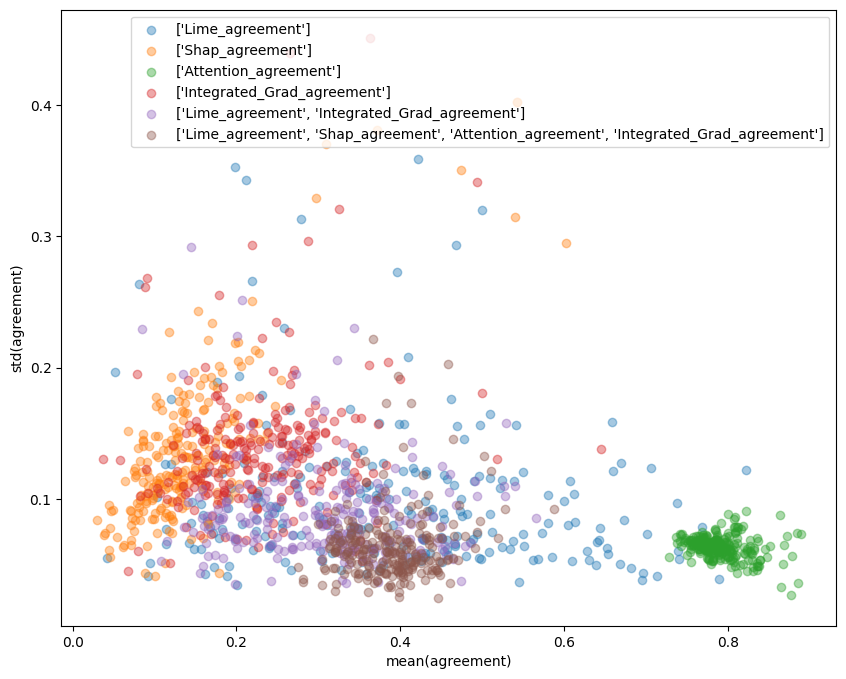

In [20]:
plt.figure(figsize=(10,8))
for mt in agreement_metrics:
    temp = df[['Test_example']].copy()
    temp['agreement'] = df[mt].mean(axis=1)
     
    stds = temp.groupby('Test_example')['agreement'].std()
    means = temp.groupby('Test_example')['agreement'].mean()

    plt.scatter(x = means, y = stds, label = mt, alpha = 0.4)
    plt.xlabel('mean(agreement)')
    plt.ylabel('std(agreement)')
    plt.legend()

### 2D Agreement plots for specific examples

In [396]:


def simil(a, b, simil_type = 'cosine'):
    if simil_type == 'cosine':
        return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    elif simil_type == 'dot':
        return np.dot(a, b)
    
# These examples are hatespeech, where our inter ensemble gets it right and majority baseline gets it wrong
np.where(((all_ensemble_preds['True Label'] == 1) & (all_ensemble_preds['Lime_agreement_Shap_agreement_Attention_agreement_Integrated_Grad_agreement_modal_vote'] > 0.5) & (all_ensemble_preds['majority_baseline'] < 0.5)))

(array([ 10,  98, 122, 152, 155, 201, 215]),)

In [397]:
# Which example shall we look at?
idx = 98

simil_type = 'cosine' # 'cosine' or 'dot'

Interpretability ensemble modal vote takes the following model: bert_medium_rand_3


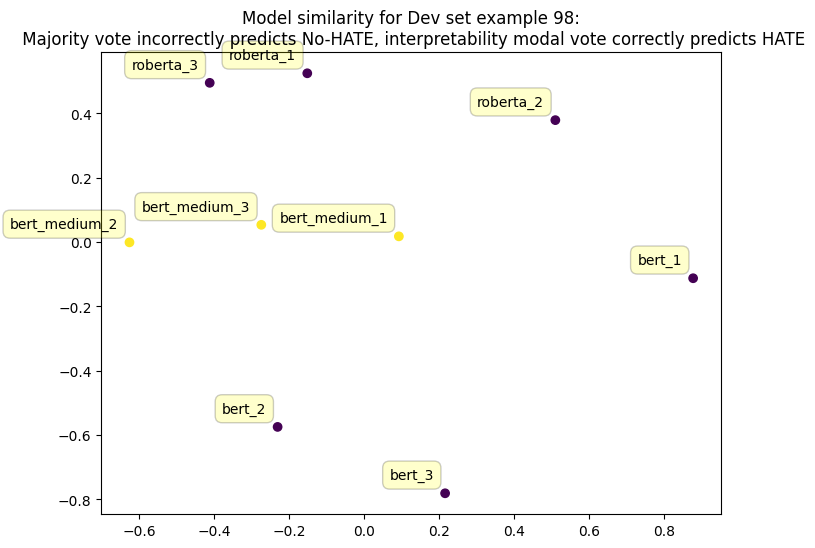

In [398]:
this_example = df[df['Test_example'] == idx].copy()

lime_scores = this_example['Lime_unified'].values
shap_scores = this_example['Shap_unified'].values + 1e-8
attn_scores = this_example['Attention_unified'].values
intg_scores = this_example['Integrated_Grad_unified'].values

lime_agreement = np.array([[simil(a, b, simil_type) for b in lime_scores] for a in lime_scores])
shap_agreement = np.array([[simil(a, b, simil_type) for b in shap_scores] for a in shap_scores])
attn_agreement = np.array([[simil(a, b, simil_type) for b in attn_scores] for a in attn_scores])
intg_agreement = np.array([[simil(a, b, simil_type) for b in intg_scores] for a in intg_scores])

#dist_matrix = (1 - lime_agreement) + (1 - shap_agreement) + (1 - attn_agreement) + (1 - intg_agreement)
dist_matrix = (1 - lime_agreement)

# convert distance matrix to 2D embedding
mds = manifold.MDS(n_components=2, dissimilarity="precomputed",
                   random_state=42, normalized_stress = 'auto')
results = mds.fit(dist_matrix)
coords = results.embedding_

# plot the result
fix, axs = plt.subplots(figsize = (8,6))
axs.scatter(coords[:, 0], coords[:, 1], marker = 'o', c = this_example['Predicted Label'])#, s = (4 - dist_matrix).sum(axis=0))
#plt.legend()
plt.title(f'Model similarity for Dev set example {idx}:\n Majority vote incorrectly predicts No-HATE, interpretability modal vote correctly predicts HATE')
for label, x, y in zip(this_example['Model_id'], coords[:, 0], coords[:, 1]):
    plt.annotate(
        label[:-6] + label[-1],
        xy = (x, y), xytext = (-8, 8),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.2))

chosen_inter_model = this_example['Model_id'].values[dist_matrix.sum(axis=0).argmin()]
print(f"Interpretability ensemble modal vote takes the following model: {chosen_inter_model}")

<Axes: >

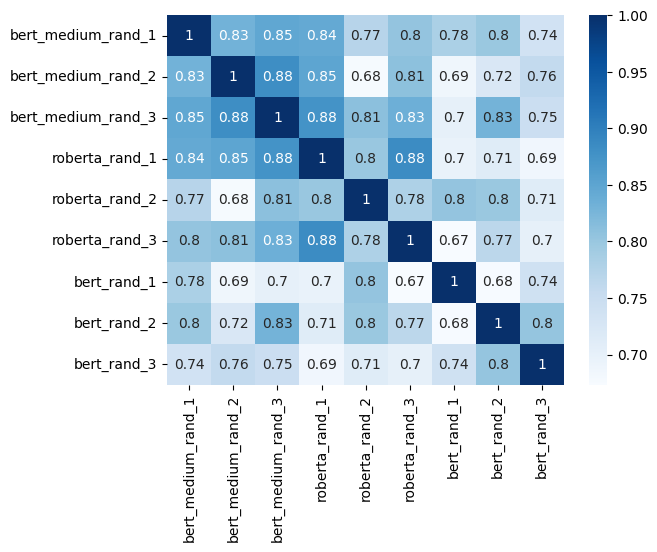

In [399]:


sns.heatmap((4 - dist_matrix)/4,
            xticklabels = this_example['Model_id'], yticklabels = this_example['Model_id'],
            cmap='Blues', annot=True)

In [384]:
' '.join(this_example['Tokens_unified'].values[0])

"<sos> if you want to hear what a black`` intellectual''( lol) sounds like, check out the woman in this video trying to debate dr. william shockley. <eos>"